Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests
from keras.callbacks import History 
history = History()
API_KEY = 'ei_34549284a9dad952ca4af9d9f859d70eb37746c157032f261972412d21df25e6'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/86484/training/68/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/86484/training/68/y')


2022-03-15 14:35:46.714247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 14:35:46.714304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Fire", "Noise", "Unknown", "Weather" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


2022-03-15 14:36:10.797744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 14:36:10.797795: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 14:36:10.797831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PC-Matt): /proc/driver/nvidia/version does not exist
2022-03-15 14:36:10.798198: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model:

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
channels = 1
columns = 40
rows = int(input_length / (columns * channels))
model.add(Reshape((rows, columns, channels), input_shape=(input_length, )))
model.add(Conv2D(8, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/200
113/113 - 2s - loss: 1.0119 - accuracy: 0.5362 - val_loss: 0.7742 - val_accuracy: 0.7472 - 2s/epoch - 21ms/step
Epoch 2/200
113/113 - 2s - loss: 0.7922 - accuracy: 0.6942 - val_loss: 0.5449 - val_accuracy: 0.7996 - 2s/epoch - 14ms/step
Epoch 3/200
113/113 - 2s - loss: 0.6405 - accuracy: 0.7733 - val_loss: 0.3944 - val_accuracy: 0.8586 - 2s/epoch - 14ms/step
Epoch 4/200
113/113 - 2s - loss: 0.5358 - accuracy: 0.8097 - val_loss: 0.3842 - val_accuracy: 0.8664 - 2s/epoch - 14ms/step
Epoch 5/200
113/113 - 1s - loss: 0.5004 - accuracy: 0.8337 - val_loss: 0.3408 - val_accuracy: 0.8831 - 1s/epoch - 13ms/step
Epoch 6/200
113/113 - 2s - loss: 0.4618 - accuracy: 0.8382 - val_loss: 0.3459 - val_accuracy: 0.8719 - 2s/epoch - 13ms/step
Epoch 7/200
113/113 - 2s - loss: 0.4058 - accuracy: 0.8613 - val_loss: 0.2683 - val_accuracy: 0.9020 - 2s/epoch - 14ms/step
Epoch 8/200
113/113 - 1s - loss: 0.3750 - accuracy: 0.8713 - val_loss: 0.3940 - val_accuracy: 0.8831 - 1s/epoch - 13ms/step
Epoch 9/

Epoch 67/200
113/113 - 2s - loss: 0.1884 - accuracy: 0.9379 - val_loss: 0.2046 - val_accuracy: 0.9399 - 2s/epoch - 15ms/step
Epoch 68/200
113/113 - 2s - loss: 0.1753 - accuracy: 0.9407 - val_loss: 0.2666 - val_accuracy: 0.9287 - 2s/epoch - 14ms/step
Epoch 69/200
113/113 - 2s - loss: 0.1555 - accuracy: 0.9446 - val_loss: 0.2776 - val_accuracy: 0.9321 - 2s/epoch - 14ms/step
Epoch 70/200
113/113 - 2s - loss: 0.1474 - accuracy: 0.9510 - val_loss: 0.1960 - val_accuracy: 0.9388 - 2s/epoch - 14ms/step
Epoch 71/200
113/113 - 2s - loss: 0.1587 - accuracy: 0.9490 - val_loss: 0.1926 - val_accuracy: 0.9443 - 2s/epoch - 14ms/step
Epoch 72/200
113/113 - 1s - loss: 0.1599 - accuracy: 0.9423 - val_loss: 0.2137 - val_accuracy: 0.9332 - 1s/epoch - 13ms/step
Epoch 73/200
113/113 - 2s - loss: 0.2136 - accuracy: 0.9281 - val_loss: 0.2146 - val_accuracy: 0.9187 - 2s/epoch - 14ms/step
Epoch 74/200
113/113 - 2s - loss: 0.2284 - accuracy: 0.9315 - val_loss: 0.1702 - val_accuracy: 0.9443 - 2s/epoch - 13ms/step


Epoch 133/200
113/113 - 1s - loss: 0.1863 - accuracy: 0.9368 - val_loss: 0.2464 - val_accuracy: 0.9254 - 1s/epoch - 13ms/step
Epoch 134/200
113/113 - 2s - loss: 0.1325 - accuracy: 0.9571 - val_loss: 0.2123 - val_accuracy: 0.9388 - 2s/epoch - 14ms/step
Epoch 135/200
113/113 - 1s - loss: 0.1237 - accuracy: 0.9588 - val_loss: 0.1707 - val_accuracy: 0.9488 - 1s/epoch - 12ms/step
Epoch 136/200
113/113 - 1s - loss: 0.1477 - accuracy: 0.9543 - val_loss: 0.2060 - val_accuracy: 0.9465 - 1s/epoch - 12ms/step
Epoch 137/200
113/113 - 1s - loss: 0.1184 - accuracy: 0.9610 - val_loss: 0.2318 - val_accuracy: 0.9443 - 1s/epoch - 12ms/step
Epoch 138/200
113/113 - 1s - loss: 0.1323 - accuracy: 0.9552 - val_loss: 0.1781 - val_accuracy: 0.9488 - 1s/epoch - 13ms/step
Epoch 139/200
113/113 - 1s - loss: 0.1400 - accuracy: 0.9540 - val_loss: 0.4583 - val_accuracy: 0.8686 - 1s/epoch - 12ms/step
Epoch 140/200
113/113 - 1s - loss: 0.2039 - accuracy: 0.9343 - val_loss: 0.2651 - val_accuracy: 0.9298 - 1s/epoch - 12

113/113 - 2s - loss: 0.0937 - accuracy: 0.9685 - val_loss: 0.2216 - val_accuracy: 0.9410 - 2s/epoch - 14ms/step
Epoch 199/200
113/113 - 2s - loss: 0.1127 - accuracy: 0.9635 - val_loss: 0.2431 - val_accuracy: 0.9276 - 2s/epoch - 14ms/step
Epoch 200/200
113/113 - 2s - loss: 0.1134 - accuracy: 0.9632 - val_loss: 0.2104 - val_accuracy: 0.9388 - 2s/epoch - 14ms/step


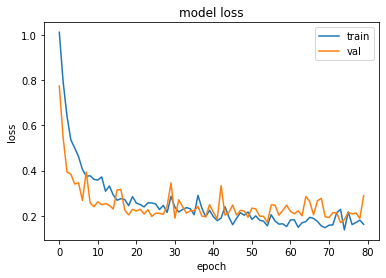

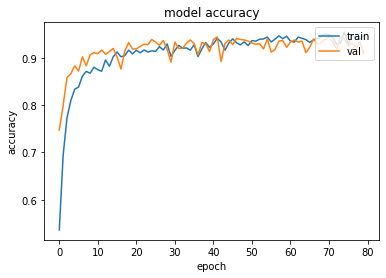

In [7]:
import keras
from matplotlib import pyplot as plt

loss=history.history['loss']
loss=loss[:80]
plt.plot(loss)
val_loss=history.history['val_loss']
val_loss=val_loss[:80]
plt.plot(val_loss)



plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

acc=history.history['accuracy']
acc=acc[:80]
plt.plot(acc)
vacc=history.history['val_accuracy']
vacc=vacc[:80]
plt.plot(vacc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()